# Novelty Analysis

* Let $\theta_i$ be the output from the block model estimation.
* Let $\theta_i = \theta_i / \sum_j\theta_{ij}$.
* The novelty of combination $h$ is defined as $-\log\sum_k\prod_{i\in h}\theta_{ik}$.

## Workbench

In [1]:
import numpy as np
import scipy.sparse as ssp
import random
from collections import Counter
from scipy.stats import dirichlet, pearsonr, poisson, rankdata, gaussian_kde
import sys
import pickle
import time
from multiprocessing import Pool,cpu_count
import pandas as pd
import itertools
from functools import partial
from sklearn.manifold import MDS,TSNE

In [2]:
%matplotlib inline
import pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
from matplotlib import cm, ticker
from adjustText import adjust_text
#from bokeh.plotting import figure, output_notebook, show
#output_notebook()

In [3]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg, end='', flush=True)
        self.start_time=time.time()
    def stop(self,msg=''):
        if msg:
            print("{}: {:2f} seconds".format(msg,time.time()-self.start_time), flush=True)
        else:
            print("Elapsed time: {:2f} seconds".format(time.time()-self.start_time), flush=True)
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

## Load data

In [4]:
def load_date(filename):
    tic=Stopwatch()
    tic.go("Loading paper dates {} from disk...".format(filename))
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    tic.stop()
    return A

def load_hypergraph(filename):
    tic=Stopwatch()
    tic.go("Loading file {} from disk...".format(filename))
    pkl_file = open(filename, 'rb')
    (row,col) = pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(19916562, max(col)+1),dtype=np.int8)
    tic.stop()
    return A

In [5]:
tic.go('Loading citation data...')
citations=pickle.load(open('../data/medline/citations.pkl','rb'),encoding='latin1').tocsr()
tic.stop()
# Load hypergraphs
PM=[] # paper by mesh terms
for i in ['chemical','disease','method']:
    PM.append(load_hypergraph('../data/medline/'+i+'.pkl'))
PM=ssp.hstack(PM).tocsr()
PJ=load_hypergraph('../data/medline/journals.pkl').tocsr() # paper by journal

paper_dates=load_date('../data/medline/paper_dates.pkl') # publication date

id2chemical=pickle.load(open('../data/medline/id2chemical.pkl','rb'),encoding='latin1')
id2disease=pickle.load(open('../data/medline/id2disease.pkl','rb'),encoding='latin1')
id2method=pickle.load(open('../data/medline/id2method.pkl','rb'),encoding='latin1')
id2name=np.array(id2chemical+id2disease+id2method)

Loading citation data...

/tmp/ipykernel_2288/353398918.py:2: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  citations=pickle.load(open('../data/medline/citations.pkl','rb'),encoding='latin1').tocsr()


Elapsed time: 11.148995 seconds
Loading file ../data/medline/chemical.pkl from disk...Elapsed time: 7.916620 seconds
Loading file ../data/medline/disease.pkl from disk...Elapsed time: 4.680053 seconds
Loading file ../data/medline/method.pkl from disk...Elapsed time: 6.632378 seconds
Loading file ../data/medline/journals.pkl from disk...Elapsed time: 105.472689 seconds
Loading paper dates ../data/medline/paper_dates.pkl from disk...Elapsed time: 2.079100 seconds


In [6]:
thetas_M,_,times_M=pickle.load(open('../Fitted_Model/block_model_medline_mesh.pkl','rb'))
thetas_J,_,times_J=pickle.load(open('../Fitted_Model/block_model_medline_journal.pkl','rb'))

## Calculation

In [7]:
def get_propensity(x):
    h=G[x,:].nonzero()[1]
    if h.size > 0:
        s=theta[h,:].prod(axis=0).sum()
    else:
        s=np.nan
    return (h.size,s)

In [16]:
print([(times_M==1951).nonzero()[0][0]])

[np.int64(4)]


In [10]:
years=np.arange(1965,2001)
dfs=[]
for t in years:
    papers=(paper_dates==t).nonzero()[0]
    tic.go('Time: {} | Papers: {} | '.format(t,len(papers)))
    df=pd.DataFrame({'ID':papers})
    df['time']=t
    # get content propensity
    theta=thetas_M[(times_M==t).nonzero()[0][0]]
    G=PM
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['terms']=a
    df['pM']=b
    # get context novelty
    theta=thetas_J[(times_J==t).nonzero()[0][0]]
    G=PJ
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['refs']=a
    df['pJ']=b
    dfs.append(df)
    tic.stop('Time cost')

Time: 1965 | Papers: 154666 | Time cost: 8.765250 seconds
Time: 1966 | Papers: 156711 | Time cost: 8.348016 seconds
Time: 1967 | Papers: 168406 | Time cost: 8.962640 seconds
Time: 1968 | Papers: 184234 | Time cost: 9.758418 seconds
Time: 1969 | Papers: 192312 | Time cost: 10.529804 seconds
Time: 1970 | Papers: 195367 | Time cost: 10.393409 seconds
Time: 1971 | Papers: 199313 | Time cost: 10.539887 seconds
Time: 1972 | Papers: 204058 | Time cost: 10.999472 seconds
Time: 1973 | Papers: 207236 | Time cost: 11.147650 seconds
Time: 1974 | Papers: 210733 | Time cost: 11.428981 seconds
Time: 1975 | Papers: 221837 | Time cost: 11.931665 seconds
Time: 1976 | Papers: 226115 | Time cost: 12.153629 seconds
Time: 1977 | Papers: 232439 | Time cost: 12.607119 seconds
Time: 1978 | Papers: 242206 | Time cost: 12.956378 seconds
Time: 1979 | Papers: 251212 | Time cost: 13.573505 seconds
Time: 1980 | Papers: 249876 | Time cost: 13.434354 seconds
Time: 1981 | Papers: 251146 | Time cost: 13.592483 seconds
T

In [11]:
years=np.arange(1965,2001)
dfs=[]
for t in years:
    papers=(paper_dates==t).nonzero()[0]
    tic.go('Time: {} | Papers: {} | '.format(t,len(papers)))
    df=pd.DataFrame({'ID':papers})
    df['time']=t
    # get content propensity
    theta=thetas_M[(times_M==t).nonzero()[0][0]]
    G=PM
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['terms']=a
    df['pM']=b
    # get context novelty
    theta=thetas_J[(times_J==t).nonzero()[0][0]]
    G=PJ
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_propensity, df['ID'])
    a,b=zip(*res)
    df['refs']=a
    df['pJ']=b
    dfs.append(df)
    tic.stop('Time cost')

Time: 1965 | Papers: 154666 | Time cost: 8.183250 seconds
Time: 1966 | Papers: 156711 | Time cost: 8.417357 seconds
Time: 1967 | Papers: 168406 | Time cost: 9.171055 seconds
Time: 1968 | Papers: 184234 | Time cost: 9.910507 seconds
Time: 1969 | Papers: 192312 | Time cost: 10.316463 seconds
Time: 1970 | Papers: 195367 | Time cost: 10.566104 seconds
Time: 1971 | Papers: 199313 | Time cost: 10.697594 seconds
Time: 1972 | Papers: 204058 | Time cost: 11.063666 seconds
Time: 1973 | Papers: 207236 | Time cost: 11.181892 seconds
Time: 1974 | Papers: 210733 | Time cost: 11.418297 seconds
Time: 1975 | Papers: 221837 | Time cost: 11.938323 seconds
Time: 1976 | Papers: 226115 | Time cost: 12.166913 seconds
Time: 1977 | Papers: 232439 | Time cost: 12.600734 seconds
Time: 1978 | Papers: 242206 | Time cost: 13.024673 seconds
Time: 1979 | Papers: 251212 | Time cost: 13.580929 seconds
Time: 1980 | Papers: 249876 | Time cost: 13.723684 seconds
Time: 1981 | Papers: 251146 | Time cost: 13.616397 seconds
T

In [12]:
corrs=[]
corr_p=[]
for df in dfs:
    df2=df[['pM','pJ']].dropna()
    c,p=pearsonr(df2['pM'],df2['pJ'])
    corrs.append(c)
    corr_p.append(p)

In [13]:
corrs=np.array(corrs)
corr_p=np.array(corr_p)
corrs[corr_p>0.05]=0

In [14]:
np.median(corrs),np.mean(corrs),min(corr_p),max(corr_p)

(np.float64(0.0),
 np.float64(0.012175610287967587),
 np.float64(6.466779300238365e-191),
 np.float64(0.9603766179536892))

In [15]:
def get_novelty(x):
    h=G[x,:].nonzero()[1]
    if h.size > 0:
        s=theta[h,:].prod(axis=0).sum()
    else:
        s=np.nan
    return (h.size,s)

In [16]:
years=np.arange(1965,2001)
dfs=[]
for t in years:
    papers=(paper_dates==t+1).nonzero()[0]
    tic.go('Time: {} | Papers: {} | '.format(t+1,len(papers)))
    df=pd.DataFrame({'ID':papers})
    df['time']=t+1
    # get citation counts
    c=citations[papers+1,:].sum(axis=1).A.ravel()
    df['cites']=c
    df['hit']=c>np.percentile(c,90)
    # get content novelty
    theta=thetas_M[(times_M==t).nonzero()[0][0]]
    theta=theta/theta.sum(axis=1).reshape(theta.shape[0],1)
    G=PM
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_novelty, df['ID'])
    a,b=zip(*res)
    df['terms']=a
    df['sM']=b
    # get context novelty
    theta=thetas_J[(times_J==t).nonzero()[0][0]]
    theta=theta/theta.sum(axis=1).reshape(theta.shape[0],1)
    G=PJ
    with Pool(cpu_count()-1) as pool:
        res=pool.map(get_novelty, df['ID'])
    a,b=zip(*res)
    df['refs']=a
    df['sJ']=b
    dfs.append(df)
    tic.stop('Time cost')

Time: 1966 | Papers: 156711 | Time cost: 8.727583 seconds
Time: 1967 | Papers: 168406 | Time cost: 9.159510 seconds
Time: 1968 | Papers: 184234 | Time cost: 10.041190 seconds
Time: 1969 | Papers: 192312 | Time cost: 10.475922 seconds
Time: 1970 | Papers: 195367 | Time cost: 10.613294 seconds
Time: 1971 | Papers: 199313 | Time cost: 10.720512 seconds
Time: 1972 | Papers: 204058 | Time cost: 11.151979 seconds
Time: 1973 | Papers: 207236 | Time cost: 11.276042 seconds
Time: 1974 | Papers: 210733 | Time cost: 11.576899 seconds
Time: 1975 | Papers: 221837 | Time cost: 12.172948 seconds
Time: 1976 | Papers: 226115 | Time cost: 12.266489 seconds
Time: 1977 | Papers: 232439 | Time cost: 12.790235 seconds
Time: 1978 | Papers: 242206 | Time cost: 13.056920 seconds
Time: 1979 | Papers: 251212 | Time cost: 13.632699 seconds
Time: 1980 | Papers: 249876 | Time cost: 13.725825 seconds
Time: 1981 | Papers: 251146 | Time cost: 13.901697 seconds
Time: 1982 | Papers: 260583 | Time cost: 14.454872 seconds

### Save results

In [17]:
with open('../Results/novelty_medline_results.pkl','wb') as outfile2:
    pickle.dump([dfs,years],outfile2)

## Results

In [22]:
with open('../Results/novelty_medline_results.pkl','rb') as infile:
     dfs,years=pickle.load(infile)

In [47]:
import numpy as np
import pickle

# Assume you have a single paper's measures
sM_paper = 1.000000  # Replace with actual value
sJ_paper = 3.068687e-21  # Replace with actual value

# Compute the novelty values for the paper
x_content_paper = -np.log(sM_paper)
x_context_paper = -np.log(sJ_paper + 1)

# For demonstration, using values from the 1966 data. In practice, you should use
# the bin edges and values from the relevant year or an average across years.
i = (years == 2000).nonzero()[0][0]

# Extract bin edges from previously computed values
df = dfs[i]
xbins_content, _ = np.unique(np.percentile(-np.log(df.sM), percentitles), return_index=True)
xbins_context, _ = np.unique(np.percentile(-np.log(df.sJ + 1), percentitles), return_index=True)

# Determine which bin the paper's novelty measure falls into
def find_bin(x, bins):
    return np.digitize(x, bins) - 1

# Compute the bin index
bin_index_content = find_bin(x_content_paper, xbins_content)
bin_index_context = find_bin(x_context_paper, xbins_context)

# Extract the novelty probabilities from X_m and X_j
Y_m_values = np.hstack(Y_m)
Y_j_values = np.hstack(Y_j)

# Get the novelty probabilities for the paper
novelty_prob_content = Y_m_values[bin_index_content]
novelty_prob_context = Y_j_values[bin_index_context]

print(f'Content Novelty Probability: {novelty_prob_content}')
print(f'Context Novelty Probability: {novelty_prob_context}')

Content Novelty Probability: 0.22876910210598342
Context Novelty Probability: 0.22788782985987624


In [46]:
print(df.sM)

0         0.000778
1         0.000629
2         0.001199
3         1.000000
4         1.000000
            ...   
479429    0.041522
479430    0.194478
479431    0.004480
479432    0.020900
479433    0.007508
Name: sM, Length: 479434, dtype: float64


### Novelty and hit paper

In [23]:
%%time
percentitles=np.linspace(0,100,30)
X_m=[]
Y_m=[]
X_j=[]
Y_j=[]
for t in range(1966,2000):
    i=(years==t).nonzero()[0][0]
    df=dfs[i].loc[dfs[i].terms>1,['sM','hit']].dropna()
    x=-np.log(df.sM)
    xbins,indx=np.unique(np.percentile(x, percentitles), return_index=True)
    H,_=np.histogram(x,xbins)
    H2,_=np.histogram(x[df.hit],xbins)
    y=H2/H
    Y_m.append(y)
    X_m.append((percentitles[indx[1:]]+percentitles[indx[:-1]])/2)
    
    df=dfs[i].loc[dfs[i].refs>1,['sJ','hit']].dropna()
    x=-np.log(df.sJ+1)
    xbins,indx=np.unique(np.percentile(x, percentitles), return_index=True)
    H,_=np.histogram(x,xbins)
    H2,_=np.histogram(x[df.hit],xbins)
    y=H2/H
    Y_j.append(y)
    X_j.append((percentitles[indx[1:]]+percentitles[indx[:-1]])/2)

CPU times: user 1.46 s, sys: 14.2 ms, total: 1.48 s
Wall time: 1.48 s


In [34]:
print(X_m)

[ 1.72413793  5.17241379  8.62068966 12.06896552 15.51724138 18.96551724
 22.4137931  25.86206897 29.31034483 32.75862069 36.20689655 39.65517241
 43.10344828 46.55172414 50.         53.44827586 56.89655172 60.34482759
 63.79310345 67.24137931 70.68965517 74.13793103 77.5862069  81.03448276
 84.48275862 87.93103448 91.37931034 94.82758621 98.27586207  1.72413793
  5.17241379  8.62068966 12.06896552 15.51724138 18.96551724 22.4137931
 25.86206897 29.31034483 32.75862069 36.20689655 39.65517241 43.10344828
 46.55172414 50.         53.44827586 56.89655172 60.34482759 63.79310345
 67.24137931 70.68965517 74.13793103 77.5862069  81.03448276 84.48275862
 87.93103448 91.37931034 94.82758621 98.27586207  1.72413793  5.17241379
  8.62068966 12.06896552 15.51724138 18.96551724 22.4137931  25.86206897
 29.31034483 32.75862069 36.20689655 39.65517241 43.10344828 46.55172414
 50.         53.44827586 56.89655172 60.34482759 63.79310345 67.24137931
 70.68965517 74.13793103 77.5862069  81.03448276 84.

In [38]:
print(Y_m)

[0.08923513 0.07390791 0.06067044 0.05347847 0.05700824 0.06753247
 0.06468366 0.09232586 0.0894712  0.08689492 0.07412653 0.08854782
 0.0878187  0.09279811 0.09537299 0.10767414 0.11024551 0.11711924
 0.12559018 0.13766234 0.13810198 0.15253837 0.14848914 0.17190083
 0.1772899  0.1785124  0.20514636 0.21416765 0.21789424 0.07075767
 0.05798915 0.05611181 0.05904444 0.06092218 0.06103679 0.07017909
 0.08282913 0.08512414 0.07072815 0.08199458 0.08282913 0.08700188
 0.09451283 0.09618193 0.10223242 0.10557062 0.11641978 0.12309618
 0.13331942 0.13790945 0.14354267 0.1614855  0.16336324 0.18109743
 0.19570207 0.21343626 0.22950136 0.23863162 0.06952925 0.05731731
 0.05767332 0.05539187 0.05909001 0.06342328 0.07819578 0.08311995
 0.06854442 0.07268072 0.07287768 0.08233209 0.08902895 0.10104392
 0.10598897 0.10222572 0.10951349 0.12408903 0.12054363 0.12684656
 0.1319677  0.1461493  0.15777034 0.16190664 0.17628521 0.18908804
 0.20701201 0.23222375 0.25901123 0.07064364 0.05749608 0.0651

In [24]:
X_m=np.hstack(X_m)
Y_m=np.hstack(Y_m)
X_j=np.hstack(X_j)
Y_j=np.hstack(Y_j)

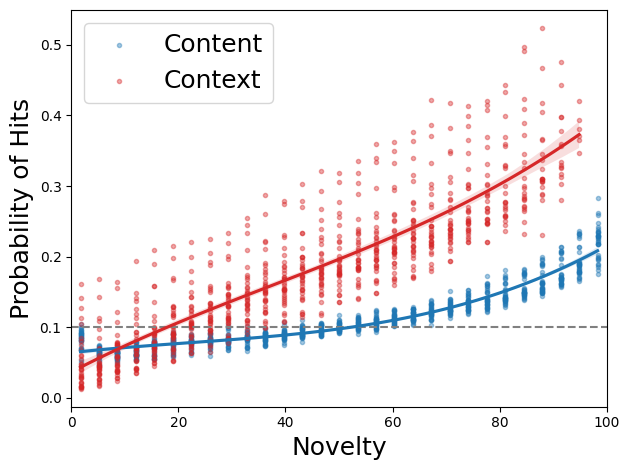

In [27]:
plt.figure()
plt.plot([0,100],[0.1]*2,'--',color='grey');
sns.regplot(x=X_m,y=Y_m,order=3,label='Content',color='C0',marker='.',scatter_kws=dict(alpha=0.4),truncate=True);
sns.regplot(x=X_j,y=Y_j,order=3,label='Context',color='C3',marker='.',scatter_kws=dict(alpha=0.4),truncate=True);
plt.xlabel('Novelty',fontsize=18)
plt.ylabel('Probability of Hits',fontsize=18);
plt.legend(loc='best',fontsize=18);
plt.xlim([0,100]);
plt.tight_layout();

In [28]:
pearsonr(X_m, Y_m)

PearsonRResult(statistic=np.float64(0.9048153313910556), pvalue=np.float64(0.0))

In [29]:
pearsonr(X_j, Y_j)

PearsonRResult(statistic=np.float64(0.876174271473947), pvalue=np.float64(2.7903680591133567e-272))

### Joint novelty and hit papers

In [30]:
def polyfit2d(x, y, z, order=2):
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z

In [31]:
%%time
xpercentitles=np.linspace(0,100,20)
ypercentitles=np.linspace(0,100,20)
X=[]
Y=[]
Z=[]
for t in range(1966,2000):
    i=(years==t).nonzero()[0][0]
    df=dfs[i].loc[np.bitwise_and(dfs[i].refs>1,dfs[i].terms>1),['sM','sJ','hit']].dropna()
    x=-np.log(df.sM)
    y=-np.log(df.sJ+1)
    xbins,xindx=np.unique(np.percentile(x,xpercentitles),return_index=True)
    ybins,yindx=np.unique(np.percentile(y,ypercentitles),return_index=True)
    H,_,_=np.histogram2d(x,y,[xbins,ybins])
    H2,_,_=np.histogram2d(x[df.hit],y[df.hit],[xbins,ybins])
    z=H2.T/(H.T+1)
    x,y=np.meshgrid(xpercentitles[xindx[:-1]],ypercentitles[yindx[:-1]]);     
    Y.append(y)
    X.append(x)
    Z.append(z)

CPU times: user 974 ms, sys: 2.48 ms, total: 977 ms
Wall time: 976 ms


In [961]:
X=np.vstack(X)
Y=np.vstack(Y)
Z=np.vstack(Z)

In [962]:
m=polyfit2d(X.flatten(), Y.flatten(), Z.flatten(), 4)
xnew, ynew = np.meshgrid(np.linspace(xpercentitles[0],xpercentitles[-2],50), np.linspace(ypercentitles[0],ypercentitles[-2],50))
znew=polyval2d(xnew,ynew,m)

/home/bill10/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



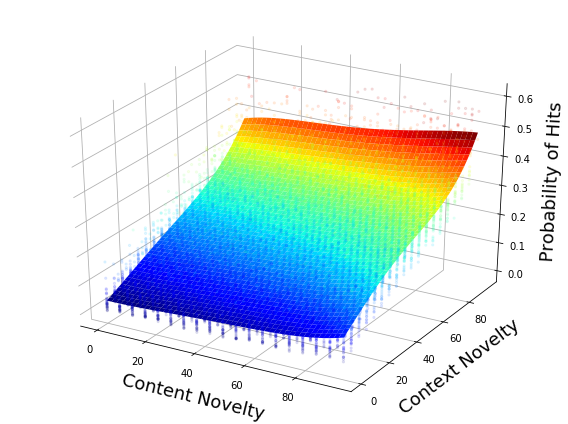

In [948]:
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.flatten(),Y.flatten(), Z.flatten(), c=Z.flatten(),alpha=0.1,marker='.',cmap='jet');
# ax.contourf(xnew,ynew,znew,50,offset=0.0, cmap='jet');
# ax.plot_surface(xnew,ynew,znew,cmap='jet',alpha=1,rcount=10,ccount=10);
ax.plot_surface(xnew,ynew,znew,cmap='jet',alpha=1);
# ax.view_init(10, -10);
# ax.view_init(10, 240);
ax.set_xlabel('Content Novelty', fontsize=18, labelpad=10);
ax.set_ylabel('Context Novelty', fontsize=18, labelpad=10);
ax.set_zlabel('Probability of Hits', fontsize=18, labelpad=10);
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0));
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0));
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0));
plt.tight_layout();
plt.savefig("../Figures/medline_joint_hits.pdf");

### Novelty vs citation

In [5]:
award_papers=pd.read_csv('../../Code/doi2pmid_awards.csv')
award_papers.loc[:,'PMID']=award_papers['PMID']-1

award_papers2=pd.read_csv('../../Award data/prizes_complete_pmids.txt',sep='\t')
award_papers2.loc[:,'pmid']=award_papers2['pmid']-1
award_papers22=pd.read_csv('../../Award data/prizes_complete_clean.tsv',sep='\t')
award_papers2=award_papers2.merge(award_papers22[['prize_id','prize']], on='prize_id')

In [66]:
%%time
X_m=[]
Y_m=[]
Z_m=[]
award_content=[]
award_content2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sM','cites']].dropna()
    df2['bins']=pd.qcut(df2['cites'],10)
    df2['percent']=df2['bins'].cat.codes
    df2['nov']=-np.log(df2.sM)
    df2['nov']=(rankdata(df2['nov'])-1)/(len(df2)-1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X_m.append(df2['bins'].cat.codes)
    Y_m.append(df2['nov'])
    Z_m.append(df2['cites'])
    a=df2.merge(award_papers,left_on='ID',right_on='PMID')
    a=a.sort_values('cites',ascending=False)
    a=a.drop_duplicates('Laureate ID')
    a=a.drop_duplicates('PMID')
    award_content.append(a)
    a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
    a=a.sort_values('cites',ascending=False)
    award_content2.append(a)
X_m=np.hstack(X_m)
Y_m=np.hstack(Y_m)
Z_m=np.hstack(Z_m)
award_content=pd.concat(award_content)
award_content2=pd.concat(award_content2)

CPU times: user 38.5 s, sys: 2.83 s, total: 41.3 s
Wall time: 8.91 s


In [67]:
content=pd.DataFrame({'X':X_m, 'Y':Y_m, 'Z':Z_m})
content["bin"]=content["X"].map(lambda x: "{}-{}%".format(x*10,(x+1)*10))
content_agg=content.groupby('X').agg([np.mean,np.std,len])
content_agg=content_agg.reset_index()

award_content['nov']=award_content['nov']
award_content2['nov']=award_content2['nov']

In [69]:
pearsonr(content_agg['X'],
            content_agg['Y']['mean'])

(0.9851392573969349, 2.0959176315583678e-07)

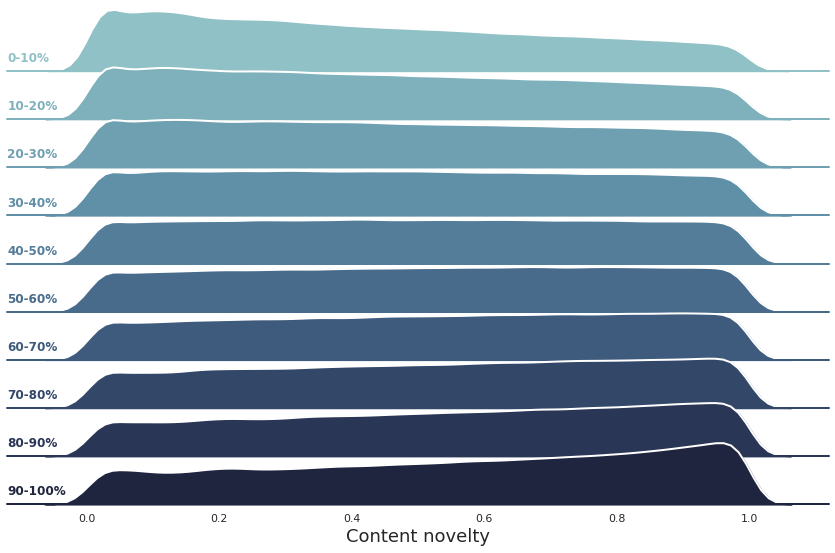

In [36]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(content, row="X", hue="X", aspect=15, height=.8, palette=pal);
g.map(sns.kdeplot, "Y",
      bw_adjust=1., clip_on=False,
      fill=True, alpha=1, linewidth=1.5, gridsize=100)
g.map(sns.kdeplot, "Y", clip_on=False, color="w", lw=2, bw_adjust=1., gridsize=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
def annotate(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, x.unique()[0], fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(annotate, "bin")
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set_xlabels("Content novelty", fontsize=18);
g.set(yticks=[])
g.despine(bottom=True, left=True);

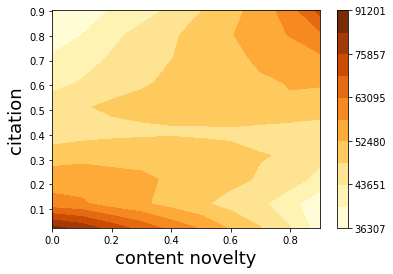

In [60]:
H,xbins,ybins=np.histogram2d(content['Y'],content['Z'],[10,10])
x,y=np.meshgrid(xbins[:-1],ybins[:-1]); 
plt.contourf(x, y, np.log10(H.T), 10, cmap="YlOrBr");
# plt.xscale('symlog');
# plt.yscale('symlog');
cbar = plt.colorbar()
cbar.set_ticklabels(np.power(10, cbar.get_ticks()).astype(int))
plt.xlabel('content novelty', fontsize=18);
plt.ylabel('citation', fontsize=18);

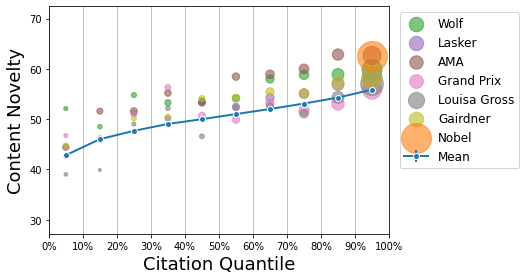

In [99]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(content_agg['X'],
            content_agg['Y']['mean'],
            fmt='o-',lw=2, mec='w', mew=1, label='Mean',
            yerr=1.96*content_agg['Y']['std']/np.sqrt(content_agg['Y']['len']),
            color='C0');

df2=award_content2[award_content2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_content[award_content['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);
plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.ylabel('Content Novelty',fontsize=18);
plt.xlabel('Citation Quantile',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();

In [70]:
%%time
X_j=[]
Y_j=[]
Z_j=[]
award_context=[]
award_context2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sJ','cites']].dropna()
    df2['bins']=pd.qcut(df2['cites'],10)
    df2['percent']=df2['bins'].cat.codes
    df2['nov']=-np.log(df2.sJ+1e-16)
    df2['nov']=(rankdata(df2['nov'])-1)/(len(df2)-1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X_j.append(df2['bins'].cat.codes)
    Y_j.append(df2['nov'])
    Z_j.append(df2['cites'])
    a=df2.merge(award_papers,left_on='ID',right_on='PMID')
    a=a.sort_values('cites',ascending=False)
    a=a.drop_duplicates('Laureate ID')
    a=a.drop_duplicates('PMID')
    award_context.append(a)
    a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
    a=a.sort_values('cites',ascending=False)
    award_context2.append(a)
X_j=np.hstack(X_j)
Y_j=np.hstack(Y_j)
Z_j=np.hstack(Z_j)
award_context=pd.concat(award_context)
award_context2=pd.concat(award_context2)

CPU times: user 42 s, sys: 2.72 s, total: 44.8 s
Wall time: 9.08 s


In [71]:
context=pd.DataFrame({'X':X_j, 'Y':Y_j, 'Z':Z_j})
context["bin"]=context["X"].map(lambda x: "{}-{}%".format(x*10,(x+1)*10))
context_agg=context.groupby('X').agg([np.mean,np.std,len])
context_agg=context_agg.reset_index()

award_context['nov']=award_context['nov']
award_context2['nov']=award_context2['nov']

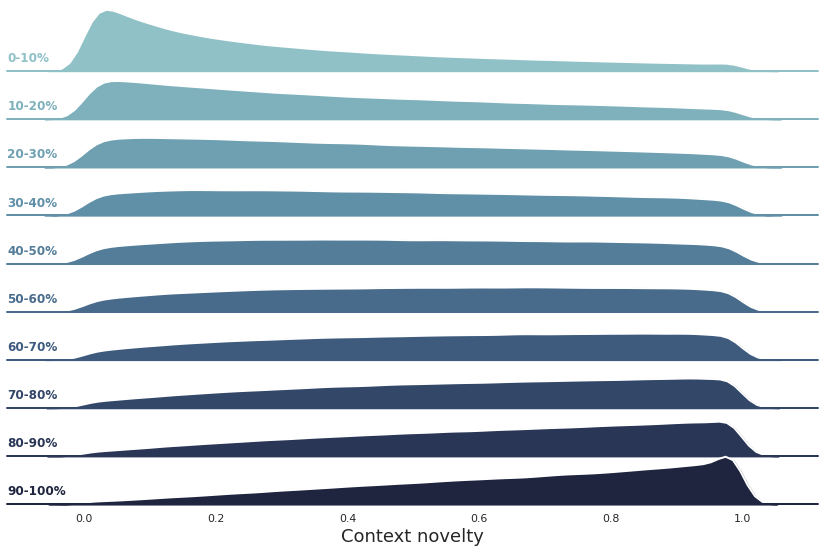

In [37]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(context, row="X", hue="X", aspect=15, height=.8, palette=pal);
g.map(sns.kdeplot, "Y",
      bw_adjust=1., clip_on=False,
      fill=True, alpha=1, linewidth=1.5, gridsize=100)
g.map(sns.kdeplot, "Y", clip_on=False, color="w", lw=2, bw_adjust=1., gridsize=100)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
def annotate(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, x.unique()[0], fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(annotate, "bin")
g.fig.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set_xlabels("Context novelty", fontsize=18);
g.set(yticks=[])
g.despine(bottom=True, left=True);

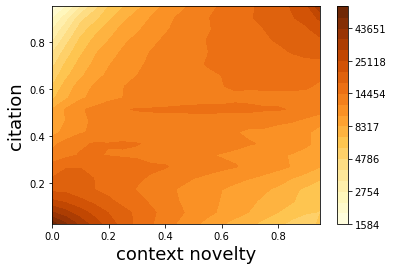

In [45]:
H,xbins,ybins=np.histogram2d(context['Y'],context['Z'],[20,20])
x,y=np.meshgrid(xbins[:-1],ybins[:-1]);
plt.contourf(x, y, np.log10(H.T), 20, cmap="YlOrBr");
# plt.xscale('symlog');
# plt.yscale('symlog');
cbar = plt.colorbar()
cbar.set_ticklabels(np.power(10, cbar.get_ticks()).astype(int))
plt.xlabel('context novelty', fontsize=18);
plt.ylabel('citation', fontsize=18);

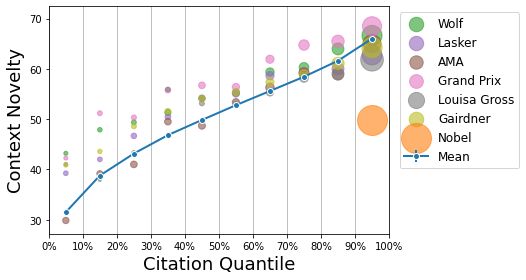

In [105]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(context_agg['X'],
            context_agg['Y']['mean'],
            fmt='o-',lw=2, mec='w', mew=1, label='Mean',
            yerr=1.96*context_agg['Y']['std']/np.sqrt(context_agg['Y']['len']),
            color='C0');

df2=award_context2[award_context2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);

df2=award_context[award_context['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'nov':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['nov']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['nov']['len']/df2['nov']['len'].sum()*900);
plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.ylabel('Context Novelty',fontsize=18);
plt.xlabel('Citation Quantile',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();

In [72]:
pearsonr(context_agg['X'], context_agg['Y']['mean'])

(0.9908280643837116, 3.062203217414638e-08)

### Citation vs novelty

In [70]:
%%time
X_m=[]
Y_m=[]
award_content=[]
award_content2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sM','cites']].dropna()
    df2['nov']=-np.log(df2.sM)
    df2['bins']=pd.qcut(df2['nov'],10)
    df2['percent']=df2['bins'].cat.codes
#     df2["cites"]=np.log(df2['cites']+1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X_m.append(df2['bins'].cat.codes)
    Y_m.append(df2['cites'])
    a=df2.merge(award_papers,left_on='ID',right_on='PMID')
    a=a.sort_values('cites',ascending=False)
    a=a.drop_duplicates('Laureate ID')
    a=a.drop_duplicates('PMID')
    award_content.append(a)
    a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
    a=a.sort_values('cites',ascending=False)
#     a=a.drop_duplicates('author_id')
    award_content2.append(a)
X_m=np.hstack(X_m)
Y_m=np.hstack(Y_m)

CPU times: user 29.4 s, sys: 1.86 s, total: 31.2 s
Wall time: 7.38 s


In [71]:
content=pd.DataFrame({'X':X_m, 'Y':Y_m})
content_agg=content.groupby('X').agg([np.mean,np.std,len])
content_agg=content_agg.reset_index()

award_content=pd.concat(award_content)
award_content2=pd.concat(award_content2)

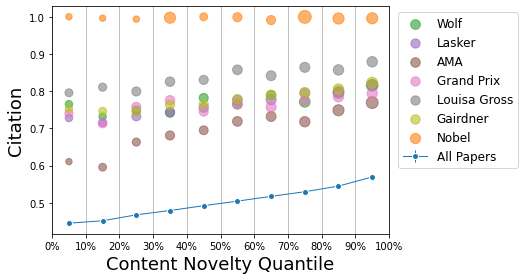

In [83]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(content_agg['X'],
            content_agg['Y']['mean'],
            fmt='o-',lw=1, mec='w', mew=1, label='All Papers',
            yerr=1.96*content_agg['Y']['std']/np.sqrt(content_agg['Y']['len']),
            color='C0');

df2=award_content2[award_content2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content2[award_content2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_content[award_content['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
# ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.xlabel('Content Novelty Quantile',fontsize=18);
plt.ylabel('Citation',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();
# plt.savefig("../Figures/medline_content_awards.pdf");

In [106]:
%%time
X=[]
Y=[]
award_context=[]
award_context2=[]
for df in dfs[6:40]:
    df2=df.loc[df.refs>1,['ID','sJ','cites']].dropna()
    df2['nov']=-np.log(df2.sJ+1e-16)
    df2['bins']=pd.qcut(df2['nov'],10)
    df2['percent']=df2['bins'].cat.codes
#     df2["cites"]=np.log(df2['cites']+1)
    df2['cites']=(rankdata(df2['cites'])-1)/(len(df2)-1)
    X.append(df2['bins'].cat.codes)
    Y.append(df2['cites'])
    a=df2.merge(award_papers,left_on='ID',right_on='PMID')
    a=a.sort_values('cites',ascending=False)
    a=a.drop_duplicates('Laureate ID')
    a=a.drop_duplicates('PMID')
    award_context.append(a)
    a=df2.merge(award_papers2,left_on='ID',right_on='pmid')
    a=a.sort_values('cites',ascending=False)
#     a=a.drop_duplicates('author_id')
    award_context2.append(a)
X=np.hstack(X)
Y=np.hstack(Y)

CPU times: user 31.9 s, sys: 2.31 s, total: 34.2 s
Wall time: 7.58 s


In [107]:
context=pd.DataFrame({'X':X, 'Y':Y})
context_agg=context.groupby('X').agg([np.mean,np.std,len])
context_agg=context_agg.reset_index()

award_context=pd.concat(award_context)
award_context2=pd.concat(award_context2)

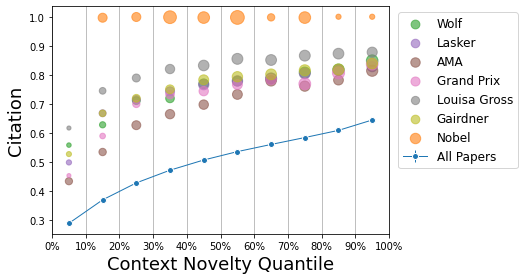

In [110]:
fig,ax=plt.subplots(figsize=(8,4))
ax.errorbar(context_agg['X'],
            context_agg['Y']['mean'],
            fmt='o-',lw=1, mec='w', mew=1, label='All Papers',
            yerr=1.96*context_agg['Y']['std']/np.sqrt(context_agg['Y']['len']),
            color='C0');

df2=award_context2[award_context2.prize.str.contains('Wolf Prize in Medicine')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C2',alpha=0.6, label='Wolf', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Lasker')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C4',alpha=0.6, label='Lasker', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('AMA')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C5',alpha=0.6, label='AMA', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Grand Prix')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C6',alpha=0.6, label='Grand Prix', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Louisa Gross')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C7',alpha=0.6, label='Louisa Gross', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context2[award_context2.prize.str.contains('Gairdner')]\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C8',alpha=0.6, label='Gairdner', 
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

df2=award_context[award_context['discipline']=='Medicine']\
   .groupby('percent')\
   .agg({'cites':[np.mean,np.std,len]}).reset_index()
ax.scatter(df2['percent'],df2['cites']['mean'], c='C1',alpha=0.6, label='Nobel',
           s=df2['cites']['len']/df2['cites']['len'].sum()*900);

plt.xticks(np.arange(0,11)-0.5,[str(i)+'%' for i in range(0,110,10)]);
plt.xlim([-0.5,9.5])
ax.grid(axis='x');
# ax.set_ylim((27.20458169209319, 72.42481383847897));
plt.xlabel('Context Novelty Quantile',fontsize=18);
plt.ylabel('Citation',fontsize=18);
plt.legend(bbox_to_anchor=(1.4, 1),fontsize=12);
plt.tight_layout();
# plt.savefig("../Figures/medline_content_awards.pdf");